# Intro To JAX

**Outline:** 

>[Setup](#scrollTo=uTgyaSXdXTV2&line=1&uniqifier=1)

>[What Is JAX](#scrollTo=JGkHAequ08zr&line=1&uniqifier=1)

>[JAX Basics](#scrollTo=Q8dT4n8DebuP&line=1&uniqifier=1)

>>[Accelerated Numpy](#scrollTo=4ZM6E8Zl01Wf&line=1&uniqifier=1)

>>[Immutability](#scrollTo=WM2fgptY1tYg&line=1&uniqifier=1)

>>[Randomness](#scrollTo=VEwV_x1iAJ7_&line=1&uniqifier=1)

>>[Agnostic Backend](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

>[JAX Transformations](#scrollTo=6qPm35e3eh2U&line=1&uniqifier=1)

>>[Jit](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

>>[Grad](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

>>[Vmap](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

>>[Pmap](#scrollTo=BWdqwGjzA-ci&line=1&uniqifier=1)

>[Demo](#)
>> linear regression haiku model, workflow

>[MNIST](#)

>[Further Reading?](#)


# Setup 

In [5]:
## Install and import anything required. Capture hides the output from the cell.

import subprocess
import os

# Based on https://stackoverflow.com/questions/67504079/how-to-check-if-an-nvidia-gpu-is-available-on-my-system
try:
    subprocess.check_output('nvidia-smi')
    print("a GPU is connected.")
except Exception: 
    # TPU or CPU
    if "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
      print("A TPU is connected.")
      import jax.tools.colab_tpu
      jax.tools.colab_tpu.setup_tpu()
    else:
      print("Only CPU accelerator is connected.")
      # x8 cpu devices - number of (emulated) host devices
      os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

import matplotlib.pyplot as plt
import numpy as np

Only CPU accelerator is connected.


In [5]:
# @title Helper Functions. (Run Cell)
import copy
from typing import Dict


def plot_performance(data: Dict, title: str):
    runs = list(data.keys())
    time = list(data.values())

    # creating the bar plot
    plt.bar(runs, time, width=0.35)

    plt.xlabel("Implementation")
    plt.ylabel("Average time taken (in s)")
    plt.title(title)
    plt.show()

    best_perf_key = min(data, key=data.get)
    all_runs_key = copy.copy(runs)

    # all_runs_key_except_best
    all_runs_key.remove(best_perf_key)

    for k in all_runs_key:
        print(
            f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!"
        )

In [21]:
# @title Check the device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 8
 Devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


# What is JAX? 

JAX is a **high performance**, numerical computing library which focuses on generating **optimized code**, as **simply** as possible.

JAX combines the best of NumPy, Autograd, and XLA (Accelerated Linear Algebra), enabling users to express complex algorithms while maintaining high performance. 

JAX focuses on providing minimal, yet powerful, low level operations and transformations that empower user to easily develop and scale scientific based experiments. 

To top it off, JAX automatically scales to all major Hardware Accelerators without the need for any code changes.


# JAX Basics

[TODO]
- What you need to know to write your first jax programs

## Pure Functions
[TODO]
- whats a pure function?
- no side effects and immutable
- reproducable
- why? 

## Accelerated Numpy 


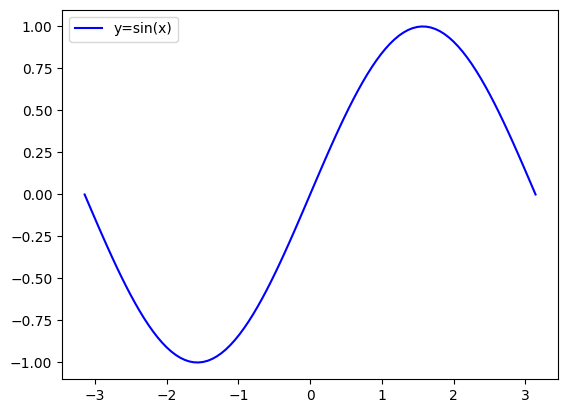

In [5]:
# 100 linearly spaced numbers from -np.pi to np.pi
x = np.linspace(-np.pi, np.pi, 100)

# the function, which is y = sin(x) here
y = np.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

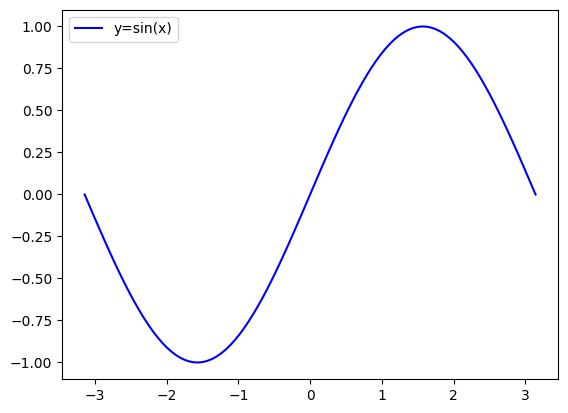

In [6]:
# 100 linearly spaced numbers from -jnp.pi to jnp.pi
x = jnp.linspace(-jnp.pi, jnp.pi, 100)

# the function, which is y = sin(x) here
y = jnp.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

## Immutability

[TODO]
- Jax data types

In [7]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


In [8]:
# JAX: immutable arrays
# Should raise an error.
try:
    x = jnp.arange(10)
    x[0] = 10
except Exception as e:
    print("Exception {}".format(e))

Exception '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


In [9]:
x = jnp.arange(10)
new_x = x.at[0].set(10)
print(f" new_x: {new_x} original x: {x}")

 new_x: [10  1  2  3  4  5  6  7  8  9] original x: [0 1 2 3 4 5 6 7 8 9]


## Randomness

In [11]:
# Set random seed
np.random.seed(42)
prng_state = np.random.get_state()

In [12]:
# @title Helper function to compare prng keys (Run Cell)
def is_prng_state_the_same(prng_1, prng_2):
    """Helper function to compare two prng keys."""
    # concat all elements in prng tuple
    list_prng_data_equal = [(a == b) for a, b in zip(prng_1, prng_2)]
    # stack all elements together
    list_prng_data_equal = np.hstack(list_prng_data_equal)
    # check if all elements are the same
    is_prng_equal = all(list_prng_data_equal)
    return is_prng_equal

In [13]:
print(
    f"sample 1 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 2 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 3 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)

sample 1 = 0.4967141530112327 Did prng state change: True
sample 2 = -0.13826430117118466 Did prng state change: True
sample 3 = 0.6476885381006925 Did prng state change: True


In [14]:
from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")
print(f"sample 2 = {random.normal(key)}")
print(f"sample 3 = {random.normal(key)}")

sample 1 = -0.1847117692232132
sample 2 = -0.1847117692232132
sample 3 = -0.1847117692232132


In [15]:
from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")

# We split the key -> new key and subkey
new_key, subkey = random.split(key)

# We use the subkey immediately and keep the new key for future splits.
# It doesn't really matter which key we keep and which one we use immediately.
print(f"sample 2 = {random.normal(subkey)}")

# We split the new key -> new key2 and subkey
new_key2, subkey = random.split(new_key)
print(f"sample 3 = {random.normal(subkey)}")

sample 1 = -0.1847117692232132
sample 2 = 1.369469404220581
sample 3 = -0.19947023689746857


##Agnostic Backend

In [16]:
size = 1000
x = np.random.normal(size=(size, size))
y = np.random.normal(size=(size, size))
numpy_time = %timeit -o -n 10 a_np = np.dot(y,x.T)

96.4 ms ± 42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
size = 1000
key1, key2 = jax.random.split(jax.random.PRNGKey(42), num=2)
x = jax.random.normal(key1, shape=(size, size))
y = jax.random.normal(key2, shape=(size, size))
jax_time = %timeit -o -n 10 jnp.dot(y, x.T).block_until_ready()

55.3 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


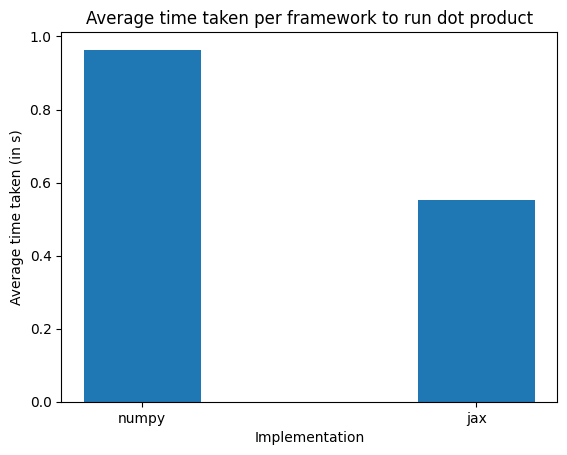

jax was 1.74 times faster than numpy !!!


In [18]:
np_average_time = np.mean(numpy_time.all_runs)
jax_average_time = np.mean(jax_time.all_runs)
data = {"numpy": np_average_time, "jax": jax_average_time}

plot_performance(data, title="Average time taken per framework to run dot product")

# JAX Transformations

##Jit Compiling

In [6]:
def relu(x):
    return jnp.where(x > 0, x, 0)
    # Another option - return jnp.maximum(x,0)

The slowest run took 11.16 times longer than the fastest. This could mean that an intermediate result is being cached.
2.53 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
663 µs ± 407 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


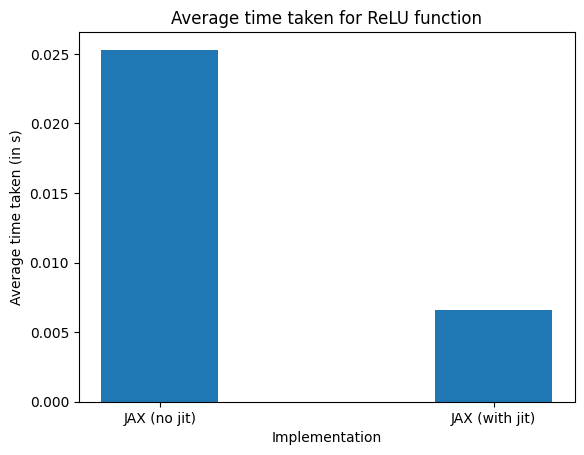

JAX (with jit) was 3.82 times faster than JAX (no jit) !!!


In [7]:
# jit our function
relu_jit = jax.jit(relu)

# generate random input
key = jax.random.PRNGKey(42)
num_random_numbers = 1000000
x = jax.random.normal(key, (num_random_numbers,))

# time normal jit function
jax_time = %timeit -o -n 10 relu(x).block_until_ready()

# Warm up/Compile - first run for jitted function
relu_jit(x).block_until_ready()

# time jitted function
jax_jit_time = %timeit -o -n 10 relu_jit(x).block_until_ready()

# Let's plot the performance difference
jax_avg_time = np.mean(jax_time.all_runs)
jax_jit_avg_time = np.mean(jax_jit_time.all_runs)
data = {"JAX (no jit)": jax_avg_time, "JAX (with jit)": jax_jit_avg_time}

plot_performance(data, title="Average time taken for ReLU function")

##Grad

In [8]:
f = lambda x: 6 * x**4 - 9 * x + 4

In [12]:
dfdx = grad(f)
dfdx_3 = dfdx(3.0)

print("Grad of f(3): ", dfdx_3)

Grad of f(3):  639.0


In [17]:
d3dx = grad(grad(grad(f)))
print("3rd order gradients of f(3): ", d3dx(3.0))

3rd order gradients of f(3):  432.0


##Vmap

In [18]:
def min_max(x):
    return jnp.array([jnp.min(x), jnp.max(x)])

In [19]:
x = jnp.arange(5)
min_max(x)

Array([0, 4], dtype=int32)

In [20]:
batch_size = 3
batched_x = np.arange(15).reshape((batch_size, -1))
print(batched_x)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]


In [21]:
@jit
def manual_batch_min_max_loop(batched_x):
    min_max_result_list = []
    for x in batched_x:
        min_max_result_list.append(min_max(x))
    return jnp.stack(min_max_result_list)


print(manual_batch_min_max_loop(batched_x))

[[ 0  4]
 [ 5  9]
 [10 14]]


In [22]:
# define our vmap function using our original single vector function
@jit
def min_max_vmap(batched_x):
    return vmap(min_max)(batched_x)


# Run it on a single vecor
## We add extra dimention in a single vector, shape changes from (5,) to (1,5), which makes the vmapping possible
x_with_leading_dim = jax.numpy.expand_dims(x, axis=0)
print(f"Single vector: {min_max_vmap(x_with_leading_dim)}")

# Run it on batch of vectors
print(f"Batch/list of vector:{min_max_vmap(batched_x)}")

Single vector: [[0 4]]
Batch/list of vector:[[ 0  4]
 [ 5  9]
 [10 14]]


In [28]:
batched_x = np.arange(50000).reshape((500, 100))

# Trace the functions with first call
manual_batch_min_max_loop(batched_x).block_until_ready()
# manual_batch_min_max_axis(batched_x).block_until_ready()
min_max_vmap(batched_x).block_until_ready()

min_max_forloop_time = %timeit -o -n 10 manual_batch_min_max_loop(batched_x).block_until_ready()
# min_max_axis_time = %timeit -o -n 10 manual_batch_min_max_axis(batched_x).block_until_ready()
min_max_vmap_time = %timeit -o -n 10 min_max_vmap(batched_x).block_until_ready()

print(
    f"Avg Times (lower is better) - Naive Implementation: {np.round(np.mean(min_max_forloop_time.all_runs),5)} Vmapped Function: {np.round(np.mean(min_max_vmap_time.all_runs),5)} "
)

850 µs ± 125 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
95.4 µs ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Avg Times (lower is better) - Naive Implementation: 0.0085 Vmapped Function: 0.00095 


##Pmap

In [29]:
# @title Illustration of Sequential Dot Product (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/not_parallel-2.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [30]:
# Let's generate a batch of size 8, each with a matrix of size (500, 600)

# Let create 8 keys, 1 for each batch
keys = jax.random.split(jax.random.PRNGKey(0), 8)

# Let create our batches
mats = jnp.stack([jax.random.normal(key, (500, 600)) for key in keys])


def dot_product_sequential():
    @jit
    def avg_dot_prod(mats):
        result = []
        # Loop through batch and compute dp
        for mat in mats:
            # dot product between the a mat and mat.T (transposed version)
            result.append(jnp.dot(mat, mat.T))
        return jnp.stack(result)

    avg_dot_prod(mats).block_until_ready()


run_sequential = %timeit -o -n 5 dot_product_sequential()

280 ms ± 57.9 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [32]:
# Let create 8 keys, 1 for each batch
keys = jax.random.split(jax.random.PRNGKey(0), 8)

# Each replicated pmapped function get a different key
mats = pmap(lambda key: jax.random.normal(key, (500, 600)))(keys)

In [33]:
print(mats.shape)

(8, 500, 600)


In [34]:
print(type(mats))

<class 'jaxlib.xla_extension.ArrayImpl'>


In [35]:
def dot_product_parallel():

    # Run a local matmul on each device in parallel (no data transfer)
    result = pmap(lambda x: jnp.dot(x, x.T))(
        mats
    ).block_until_ready()  # result.shape is (8, 5000, 5000)


run_parallel = %timeit -o -n  5 dot_product_parallel()

166 ms ± 47 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


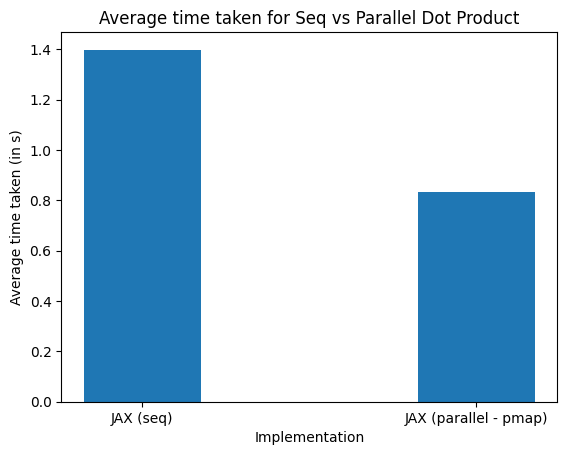

JAX (parallel - pmap) was 1.68 times faster than JAX (seq) !!!


In [36]:
# @title Let's plot the performance difference (Run Cell)

jax_parallel_time = np.mean(run_parallel.all_runs)
jax_seq_time = np.mean(run_sequential.all_runs)


data = {"JAX (seq)": jax_seq_time, "JAX (parallel - pmap)": jax_parallel_time}

plot_performance(data, title="Average time taken for Seq vs Parallel Dot Product")

# Building JAX Models

In [117]:
# @title JAX Data Parallel Linear Regression with Haiku 

import haiku as hk
import jax
from jax import numpy as jnp
import numpy as np
import functools

def model_fn(x):
  net = hk.Sequential([
    hk.Linear(output_size=1, name='linear')
  ])
  return net(x)

# Transforms the model function into a pair of pure functions using Haiku's init and apply functions.
model = hk.without_apply_rng(hk.transform(model_fn))

def loss_fn(params, xs, ys):
  """Computes the least squares error of the model's predictions on x against y."""
  pred = model.apply(params, xs)
  return jnp.mean((pred - ys) ** 2)

LEARNING_RATE = 0.005

@functools.partial(jax.pmap, axis_name='num_devices')
def update(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> Tuple[Params, jnp.ndarray]:
    """Performs one SGD update step on params using the given data."""

    # Compute the gradients on the given minibatch (individually on each device).
    loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

    # Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name='num_devices')

    # Also combine the loss. Unnecessary for the update, but useful for logging.
    loss = jax.lax.pmean(loss, axis_name='num_devices')

    # Each device performs its own update, but since we start with the same params
    # and synchronise gradients, the params stay in sync.
    new_params = jax.tree_map(
        lambda param, g: param - g * LEARNING_RATE, params, grads)

    return new_params, loss

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

# Initialise parameters and replicate across devices.
params = model.init(jax.random.PRNGKey(123), xs)
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)

def split(arr):
  """Splits the first axis of `arr` evenly across the number of devices."""
  return arr.reshape(n_devices, arr.shape[0] // n_devices, *arr.shape[1:])

# Reshape xs and ys for the pmapped `update()`.
x_split = split(xs)
y_split = split(ys)

# Actual training loop.
for i in range(1000):

  # This is where the params and data gets communicated to devices:
  replicated_params, loss = update(replicated_params, x_split, y_split)

  if i % 100 == 0:
    # Note that loss is actually an array of shape [num_devices], with identical
    # entries, because each device returns its copy of the loss.
    # So, we take the first element to print it.
    print(f"Step {i:3d}, loss: {loss[0]:.3f}")

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))


/usr/local/lib/python3.10/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Step   0, loss: 17.330
Step 100, loss: 1.568
Step 200, loss: 0.335
Step 300, loss: 0.238
Step 400, loss: 0.231
Step 500, loss: 0.230
Step 600, loss: 0.230
Step 700, loss: 0.230
Step 800, loss: 0.230
Step 900, loss: 0.230


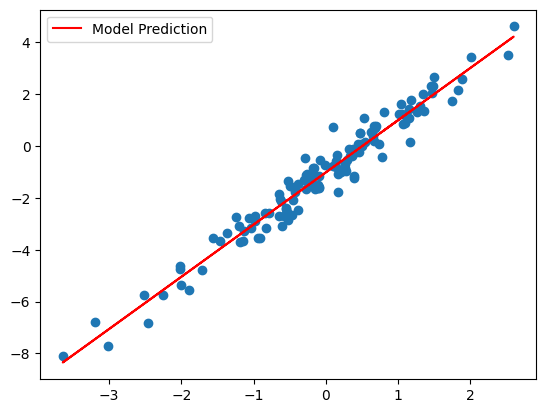

In [118]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.plot(xs, params['linear']['w'] * xs + params['linear']['b'], c='red', label='Model Prediction')
plt.legend()
plt.show()